In [1]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
from datetime import datetime
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
import tensorflow.keras.backend as K
from sklearn import decomposition

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#dont keep api key in github!!!
api_file = os.path.join('..','..','..','apikeys','steam_api_key.txt')
with open(api_file, 'r') as fin:
    api = WebAPI(key=fin.readline())

print(tf.__version__)

2.0.0


In [2]:
sns.set_style('ticks')

In [3]:
#declare interface urls
#dota2_beta should be used for testing in order to not aggressively make API requests
dota2_id = '570'
dota2_beta_id = '205790'

#get hero_list to construct a vocabulary for prediction
hero_list = api.call('IEconDOTA2_'+dota2_id+'.GetHeroes')
hero_vocab=[int(hero_id['id']) for hero_id in hero_list['result']['heroes']] 
print(len(hero_vocab))

119


# Modeling using a TFRecord dataformat

## Build TFRecord input pipeline
Need separate parse functions for every unique number of targets because we don't want to waste time reading the extra targets if they aren't needed.

In [4]:
def _parse_function(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    
    #return radiant_heroes,dire_heroes, labels
    return {'radiant_heroes':radiant_heroes,'dire_heroes': dire_heroes}, labels

In [5]:
def _parse_function_nodict(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature(5, tf.int64), #array of five 8-bit ints for heroes
        "label": tf.io.FixedLenFeature(1, tf.int64)
                }
    
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    
    labels = parsed_features['label']
    return [radiant_heroes,dire_heroes], labels

In [7]:
def _parse_function_dual(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
        {'gold_diff': gold_diff, 'radiant_win':radiant_win}

In [8]:
def _parse_function_triple(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'radiant_win':radiant_win}

In [9]:
def _parse_function_penta(example_proto):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A 2D tensors representing the heroes
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "radiant_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8 bit ints for heroes
        "dire_heroes": tf.io.FixedLenFeature([5], dtype=tf.int64), #array of five 8-bit ints for heroes
        "radiant_win" :tf.io.FixedLenFeature([1], dtype=tf.int64),
        "gold_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_gold": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "tower_damage_diff": tf.io.FixedLenFeature([1], dtype=tf.float32),
        "total_tower_damage": tf.io.FixedLenFeature([1], dtype=tf.float32)
                }
  
    parsed_features = tf.io.parse_single_example(example_proto, features)
  
    radiant_heroes = parsed_features['radiant_heroes']
    dire_heroes = parsed_features['dire_heroes']
    radiant_win = parsed_features['radiant_win']
    gold_diff = parsed_features['gold_diff']
    total_gold = parsed_features['total_gold']
    towdam_diff = parsed_features['tower_damage_diff']
    total_towdam = parsed_features['total_tower_damage']

    #return  {'radiant_heroes':radiant_heroes, 'dire_heroes':dire_heroes},\
    #       {'radiant_win':radiant_win, 'gold_diff':gold_diff}
    return [radiant_heroes,dire_heroes],\
            {'gold_diff': gold_diff,
                 'total_gold':total_gold,
                 'tower_damage_diff':towdam_diff,
                 'total_tower_damage': total_towdam,
                 'radiant_win':radiant_win}

#### Check the parse function worked

In [6]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('Dota_data',
                                          'mixed_skill',
                                          'dota2_training_data',
                                          'radiant_win_novocab_dota2_training_data.tfrecords'),
                             compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function_nodict)

In [7]:
ds = ds.shuffle(10)
print(tf.data.experimental.get_single_element(ds.take(1)))

(<tf.Tensor: id=34, shape=(2, 5), dtype=int64, numpy=
array([[ 77,  11,  64,  94,  87],
       [  6,  17,  31, 101,  34]])>, <tf.Tensor: id=35, shape=(1,), dtype=int64, numpy=array([0])>)


## Input Functions

In [9]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
# This input_fn has an option to allow for calling different parse_fn
#    based on the number of targets.
def _input_fn_multi(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type="",target_num=2):
   
    # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    
    #allow specification of number of targets needed so we can reuse input function
    if target_num==2:
        ds = ds.map(_parse_function_dual)
    elif target_num==3:
        ds = ds.map(_parse_function_triple)
    elif target_num==5:
        ds = ds.map(_parse_function_penta)
    elif target_num==1:
        ds = ds.map(_parse_function_nodict)
    else:
        raise KeyError
    
    #only shuffle if shuffle flag
    if shuffle:
        ds = ds.shuffle(10000)
        
    #take only dataset of length batch_size
    ds = ds.batch(batch_size)
    
    #make sure you can repeatedly take datasets from the TFRecord
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

In [11]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
# This input_fn call the parse_fn that return an array(not dict) of targets
def _input_fn_single_example(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
   # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function_nodict)
    
    #only shuffle if shuffle flag
    if shuffle:
        ds = ds.shuffle(10000)
    
    #take only dataset of length batch_size
    ds = ds.batch(batch_size)
    
    #make sure you can repeatedly take datasets from the TFRecord
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

In [10]:
# Create an input_fn that parses the tf.Examples from the given files,
#     and split them into features and targets. 
# Calls parse function that returns a dict of labels for feature column input
def _input_fn(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
  # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    # Return the dataset.
    return ds

## Define and train the linear model

### various iterations of linear models
First model uses feature column inputs, but I didn't like that because its more opaque what     is happening to feed that into the model

The following models use embedding column inputs with explicit transformations to give it the proper shape to be fed it into the model. Important to me was also transforming the     embedding column output to erase ordering information and preserve team information.

Suffix dual, triple, quad refer to the auxiliary targets I was trying to use to help guide the model to 1. Get better accuracy 2. Train a better embedding matrix

Auxiliary targets did not help the model gain accuracy. Embedding matrices did not seem to be very consistent, although perhaps averaging the distances between pairs could alleviate this somewhat.

In [13]:
#define the linear model with feature columns
def linear_model(optimizer, feature_columns):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Sequential` model
    '''
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

    model = tf.keras.Sequential([
        feature_layer,
        #Adds output layer with softmax activation for prediction
        tf.keras.layers.Dense(1,activation='sigmoid')
                                ])
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [13]:
#define the linear model with no feature columns
def train_linear_model_no_feature_columns(optimizer, 
                                          vocab_len, 
                                          embedding_dims,
                                          batch_size,
                                          epochs,
                                          training_path,
                                          validation_path,
                                          compression_type='',
                                          temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''
    
    #specify input layer
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    x = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single embedded vector for each team
    x = tf.keras.layers.Dense(1, activation='linear')(x)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    #Adds output layer with sigmoid activation for binary prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=all_heroes,
                           outputs=win_predict,name="linear_classifier")
    
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_single_example(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)

    validation_ds= _input_fn_single_example(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=10
    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=0,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'single_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)
    
    #plot accuracy
    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['accuracy'])
    plt.xlabel('epochs (10 steps per)')
    plt.ylabel('accuracy')
    plt.show()
    
    return history, model

In [15]:
#define the linear model with no feature columns and dual targets
def train_linear_model_dual(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    aux_pred = tf.keras.layers.Dense(1,activation='linear',
                                      name='aux_feature')(x)
    
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)

    win_inputs = tf.keras.layers.concatenate([x,aux_pred])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    dual_model = tf.keras.Model(inputs=all_heroes, outputs=[aux_pred,win_pred])
    dual_model.compile(optimizer=optimizer,
                      loss = ['mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight, 1],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]

    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=2)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=2)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag==True:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))

    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    #fit model and keep history object for returning
    steps_per_epoch=50
    history = dual_model.fit(train_ds, 
                             epochs = epochs,
                             steps_per_epoch=steps_per_epoch,
                             validation_steps=steps_per_epoch,
                             verbose=2,
                             validation_data=val_ds,
                             callbacks=[tensorboard_callback]
                            )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    dual_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)
    
    fig, (ax1,ax2)= plt.subplots(1,2,sharey=False,figsize=(5*1.6,5))
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('win_loss')
    ax2.set_ylabel('gold_loss')
    plt.show()

    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return gold_history,win_history
    return history

In [16]:
#define the linear model with no feature columns and three targets
def train_linear_model_triple(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    triple_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            win_pred])
    triple_model.compile(optimizer=optimizer,
                      loss = ['mse','mse', 'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight, 1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = triple_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=3)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=3)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = triple_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    triple_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'triple_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size': batch_size,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding)

    #plot results with loss side by side and win accuracy alone
    fig, [ax1,ax2,ax3]= plt.subplots(1,3,sharey=False,figsize=(5*1.6,5))
    ax3.plot(history.history['total_gold_loss'])
    ax2.plot(history.history['gold_diff_loss'])
    ax1.plot(history.history['radiant_win_loss'])
    ax3.set_xlabel('epochs (50 steps per)')
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win loss')
    ax2.set_ylabel('gold_diff loss')
    ax3.set_ylabel('total_gold loss')
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,1,figsize=(3*1.6,3))
    plt.plot(history.history['radiant_win_accuracy'])
    plt.xlabel('epochs (50 steps per)')
    plt.ylabel('accuracy')
    plt.show()

    #return embedding weights and history for model.fit
    return history

In [17]:
#define the linear model with no feature columns and three targets
def train_linear_model_penta(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    towdam_diff= tf.keras.layers.Dense(1,activation='linear',
                                        name = 'tower_damage_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    total_towdam = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_tower_damage')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold,
                                             towdam_diff,total_towdam])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    penta_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            towdam_diff,
                                                            total_towdam,
                                                            win_pred])
    penta_model.compile(optimizer=optimizer,
                      loss = ['mse','mse',
                              'mse','mse',
                              'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight,
                                      aux_weight,aux_weight,
                                      1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = penta_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=5)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=5)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = penta_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    penta_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'penta_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size': batch_size,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)

    #plot results with loss side by side and win accuracy alone
    fig, ax= plt.subplots(2,2,sharey=True,figsize=(5*1.6,5),sharex=True)
    ax[0,0].plot(history.history['total_gold_loss'])
    ax[0,1].plot(history.history['gold_diff_loss'])
    ax[1,0].plot(history.history['total_tower_damage_loss'])
    ax[1,1].plot(history.history['tower_damage_diff_loss'])
    #ax[0,0].set_xticks([])
    #ax[0,1].set_xticks([])
    #ax[0,1].set_yticks([])
    #ax[1,1].set_yticks([])
    ax[0,0].set_ylabel('total and diff gold loss')
    #ax[1,0].set_ylabel('gold_diff loss')
    ax[1,0].set_ylabel('total and diff tower_damage loss')
    #ax[1,1].set_ylabel('tower_damage_diff loss')
    ax[1,0].set_xlabel('epochs(50 steps per)')
    ax[1,1].set_xlabel('epochs(50 steps per)')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(1.6*3,6),sharex=True)
    ax1.plot(history.history['radiant_win_loss'])
    ax2.plot(history.history['radiant_win_accuracy'])
    #ax1.set_xticks([])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win_loss')
    ax2.set_ylabel('accuracy')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    #return embedding weights and history for model.fit
    return history

In [18]:
#define the linear model with feature columns and three targets
def train_linear_model_penta_auxconnect(optimizer, 
                             vocab_len,
                             embedding_dims,
                             batch_size,
                             epochs,
                             aux_weight,
                             training_path,
                             validation_path,
                             compression_type='',
                             temp_log_flag=True):
    '''Function to define simple keras linear model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
    Returns:
        model: A `tf.keras.Model` model
    '''
    
    all_heroes = tf.keras.Input(shape=(2,5,),name='all_heroes')

    #Put input through an embedding layer. Can make this (sort of)equivalent
    #  to an indicator column by setting dimension to 1
    x = tf.keras.layers.Embedding(input_dim=vocab_len,
                                  output_dim=embedding_dims)(all_heroes)
    
    # Adds a pooling layer with to get average team vector:
    pooled_heroes = tf.keras.layers.AveragePooling2D(pool_size=(1,5))(x)
    
    # Add a linear layer to map the average of the embedded vectors of each team
    #   to a single value for each team
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    
    #reshape to get rid of axes of length 1
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    #Adds output layer with softmax activation for prediction
    total_gold = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_gold')(x)

    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,total_gold])
    gold_diff = tf.keras.layers.Dense(1,activation='linear',
                                      name='gold_diff')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,gold_diff,total_gold])
    total_towdam = tf.keras.layers.Dense(1,activation='linear',
                                        name = 'total_tower_damage')(x)
    
    #do similar fit and processing layers starting for total_gold
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,),input_shape=(2,1,1,))(x)
    x = tf.keras.layers.concatenate([x,gold_diff,total_gold,total_towdam])
    towdam_diff= tf.keras.layers.Dense(1,activation='linear',
                                        name = 'tower_damage_diff')(x)
    
    #do similar fit and processing layers starting for radiant_win,
    #  and use gold_diff and total_gold to help predict win
    x = tf.keras.layers.Dense(1, activation='linear')(pooled_heroes)
    x = tf.keras.layers.Reshape((2,), input_shape=(2,1,1,))(x)
    win_inputs = tf.keras.layers.concatenate([x,gold_diff,total_gold,
                                             towdam_diff,total_towdam])
    win_pred = tf.keras.layers.Dense(1,activation='sigmoid',
                                     name='radiant_win')(win_inputs)
    
    #create and compile model with three outputs
    #  with auxiliary outputs deemphasized by aux_weight
    penta_model = tf.keras.Model(inputs=all_heroes, outputs=[gold_diff,
                                                            total_gold,
                                                            towdam_diff,
                                                            total_towdam,
                                                            win_pred])
    penta_model.compile(optimizer=optimizer,
                      loss = ['mse','mse',
                              'mse','mse',
                              'binary_crossentropy'],
                      loss_weights = [aux_weight,aux_weight,
                                      aux_weight,aux_weight,
                                      1/0.7],
                      metrics = ['accuracy'])
    
    #get embedding weights for returning and saving
    embedding_weights = penta_model.layers[1].get_weights()[0]
    
    #train_gold_ds, train_win_ds = _input_fn_multi(training_path,
    train_ds = _input_fn_multi(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               target_num=5)
    
    #val_gold_ds, val_win_ds = _input_fn_multi(validation_path,
    val_ds = _input_fn_multi(validation_path,
                             batch_size=batch_size,
                             compression_type=compression_type,
                             target_num=5)
    
    #log training data in temp folder unless the flag is false
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    #add tensorboard callback for model inspection/watching training/embedding 
    #  exploration in an easy way.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir,
                                                          write_images=True,
                                                          embeddings_freq=1)
    #fit model
    steps_per_epoch = 50
    history = penta_model.fit(train_ds, 
                               epochs = epochs,
                               steps_per_epoch=steps_per_epoch,
                               validation_steps=steps_per_epoch,
                               verbose=0,
                               validation_data=val_ds,
                               callbacks=[tensorboard_callback]
                               )
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    penta_model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')

    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item() #numpy can't be serialized
    training_params = dict({'model_type':'penta_target_linear_with_embedding',
                            'steps':steps_per_epoch*epochs,
                            'embedding_dims':embedding_dims,
                            'batch_size': batch_size,
                            'auxiliary_weights':aux_weight,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)

    #save embedding in numpy format for later use
    #  no hero_vocab, but that should be ok
    np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)

    #plot results with loss side by side and win accuracy alone
    fig, ax= plt.subplots(2,2,sharey=True,figsize=(5*1.6,5),sharex=True)
    ax[0,0].plot(history.history['total_gold_loss'])
    ax[0,1].plot(history.history['gold_diff_loss'])
    ax[1,0].plot(history.history['total_tower_damage_loss'])
    ax[1,1].plot(history.history['tower_damage_diff_loss'])
    ax[0,0].set_ylabel('total and diff gold loss')
    ax[1,0].set_ylabel('total and diff tower_damage loss')
    ax[1,0].set_xlabel('epochs(50 steps per)')
    ax[1,1].set_xlabel('epochs(50 steps per)')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(1.6*3,6),sharex=True)
    ax1.plot(history.history['radiant_win_loss'])
    ax2.plot(history.history['radiant_win_accuracy'])
    #ax1.set_xticks([])
    ax2.set_xlabel('epochs (50 steps per)')
    ax1.set_ylabel('radiant_win_loss')
    ax2.set_ylabel('accuracy')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    #return embedding weights and history for model.fit
    return history

### Train model (unused)
Unused function leftover from previous function hierarchy.

In [23]:
def train_model(optimizer,
                embedding_dim,
                batch_size, 
                epochs, 
                training_path, 
                validation_path, 
                compression_type=''):
    """Trains a keras model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        optimizer: A `tf.keras.optimizer` to optimize loss with
        model_type: A `string` specifying the model to use
        feature_column: An `tf.feature_column` containing input data
        epochs: A non-zero `int`, the total number of training epochs. A training epoch
          consists of a forward and backward pass using a single batch.
        batch_size: A `int` specifying the number of examples for each training step.
        feature_columns: A `set` specifying the input feature columns to use.
        training_path: A `string` specifying the path to the TFRecord training data.
        validation_path: A `string` specifying the path to the TFRecord training data.
        compression_type: A `string` specifying the type of compression used for the TFRecords
      
    Returns:
        A keras `history` object trained on the training data.
    """
    
    #make linear model
    model = linear_model(optimizer,embedding_dim,vocab_len)

    
    #get batched datasets
    training_dataset = _input_fn(training_path,
                                       batch_size=batch_size,
                                       compression_type=compression_type)
    validation_dataset = _input_fn(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type)
    
    logdir = os.path.join('..','..','..','tmp_log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    
    history = model.fit(training_dataset, 
                        epochs = epochs,
                        steps_per_epoch=10,
                        validation_steps=10,
                        verbose=0,
                        validation_data=validation_dataset,
                        callbacks=[tensorboard_callback]
                       )
    
    plt.plot(history.history['accuracy'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return history

### train no feature column win model

In [15]:
training_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_win_novocab_dota2_training_data.tfrecords')
validation_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_win_novocab_dota2_validation_data.tfrecords')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20200226-180222/saved_model/assets


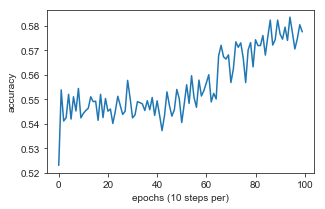

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history, model = train_linear_model_no_feature_columns(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=1,
            batch_size=1000, 
            epochs=100, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

#### Test set eval
only evaluate after finished tuning hyperparams!

In [17]:
#specify test file and load dataset
test_file_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_test_data',
                             'radiant_win_novocab_dota2_test_data.tfrecords')

#make sure batch is big to reduce noise
batch=10000
test_ds = _input_fn_single_example(test_file_novocab,
                                    batch_size=batch,
                                    compression_type='GZIP')
#unpack into array of x and y (data and labels)
x, y_true = tf.data.experimental.get_single_element(test_ds.take(1))
y_true = y_true.numpy()[:,0] #reshape to be 1D array

#make predictions
y_probs = model.predict(x)[:,0]

#convert probabilities to predicted values
y_pred = np.rint(y_probs)

print('Accuracy: %0.3f ' % (1-np.average(np.logical_xor(y_true,y_pred))))

Accuracy: 0.583 


#### Use test set eval to investigate confusion matrix

In [18]:
#make confusion matrix
conf_mat = tf.math.confusion_matrix(labels=y_true, 
                                    predictions=y_pred,
                                    num_classes=2).numpy()
conf_mat_norm = np.around(conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis], 
                          decimals=2)

conf_mat_df = pd.DataFrame(conf_mat_norm)

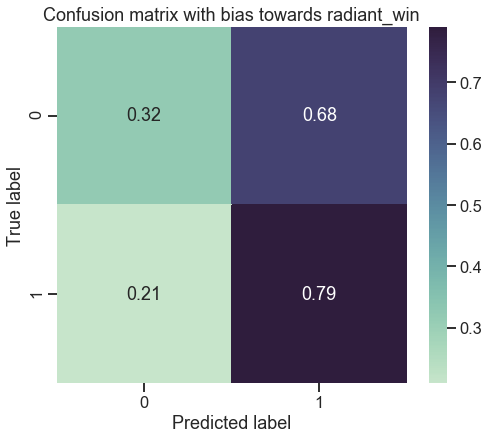

In [21]:
figure = plt.figure(figsize=(7, 6))

sns.set_context('talk')
cmap = sns.cubehelix_palette(start=0.5, rot=-0.6, as_cmap=True)

sns.heatmap(conf_mat_df, annot=True,cmap=cmap)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix with bias towards radiant_win')
plt.show()

#### Proof of concept use case for prediction of win probability of 10th pick

In [197]:
hero_dict = {}
#make dict to convert hero name to hero id
# (use reindexed id to not skip numbers and match expected input)
for i,hero in enumerate(hero_list['result']['heroes']):
    hero_dict[hero['name'][14:]]=i

In [304]:
#use games from test dataset to see if we can suggest the
#   tenth pick of the winning team
ds = ds.shuffle(10)
team,win = tf.data.experimental.get_single_element(ds.take(1))
team = team.numpy()
win = win.numpy()
last_pick_win = team[-(win-1),4]
print('team:',team)
print('win:',win)

team: [[72  7 73 13 69]
 [25 67 28 92 38]]
win: [0]


In [308]:
pred_tenth_pick=[]
#substitute last player on winning team 
#   (first row team win corresponds to win=1 so take -(win-1)
for i in range(len(hero_vocab)):
    team[-(win-1),4] = i
    team_in = np.reshape(team, (1,2,5))
    #this operation takes long so watch your looping
    prob = model.predict(team_in) 
    pred_tenth_pick.append(prob)
pred_tenth_pick = np.reshape(pred_tenth_pick,len(hero_vocab))

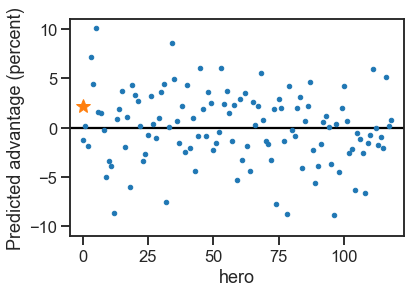

In [319]:
#win*2-1 is -1 if win=0 and +1 in win=1
#this makes the sign of the advantage match the prediction sign
plt.plot([-5,130],[0,0],'k')
pred_advantage = (pred_tenth_pick-np.average(pred_tenth_pick))*100*(win*2-1)
plt.plot(pred_advantage,'.')
plt.plot(pred_advantage[last_pick_win],'*',markersize=15)
plt.ylabel('Predicted advantage (percent)')
plt.xlabel('hero')
plt.ylim(-11,11)
plt.xlim(-5,123)
plt.show()

### train dual gold_diff win model

In [ ]:
training_file_dual_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'dual_gold_win_novocab_dota2_training_data.tfrecords')
validation_file_dual_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'dual_gold_win_novocab_dota2_validation_data.tfrecords')

Train for 50 steps, validate for 50 steps
Epoch 1/20
50/50 - 6s - loss: 0.7901 - gold_diff_loss: 1.0018 - radiant_win_loss: 0.6899 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5434 - val_loss: 0.7896 - val_gold_diff_loss: 1.0064 - val_radiant_win_loss: 0.6890 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5430
Epoch 2/20
50/50 - 4s - loss: 0.7865 - gold_diff_loss: 0.9979 - radiant_win_loss: 0.6867 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5508 - val_loss: 0.7870 - val_gold_diff_loss: 1.0016 - val_radiant_win_loss: 0.6869 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5450
Epoch 3/20
50/50 - 4s - loss: 0.7849 - gold_diff_loss: 1.0023 - radiant_win_loss: 0.6846 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5491 - val_loss: 0.7858 - val_gold_diff_loss: 1.0237 - val_radiant_win_loss: 0.6834 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5478
Epoch 4/20
50/50 - 4s - loss: 0.7857 - gold_di

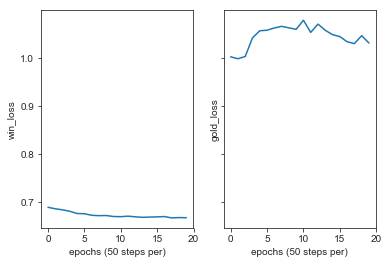

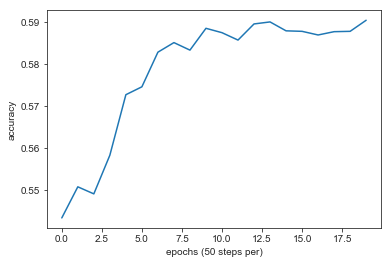

In [88]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=20, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

Train for 50 steps, validate for 50 steps
Epoch 1/40
50/50 - 8s - loss: 0.7897 - gold_diff_loss: 0.9931 - radiant_win_loss: 0.6904 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5414 - val_loss: 0.7865 - val_gold_diff_loss: 0.9884 - val_radiant_win_loss: 0.6876 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5467
Epoch 2/40
50/50 - 5s - loss: 0.7834 - gold_diff_loss: 0.9847 - radiant_win_loss: 0.6849 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5509 - val_loss: 0.7807 - val_gold_diff_loss: 0.9725 - val_radiant_win_loss: 0.6835 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5453
Epoch 3/40
50/50 - 4s - loss: 0.7764 - gold_diff_loss: 0.9729 - radiant_win_loss: 0.6791 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5629 - val_loss: 0.7715 - val_gold_diff_loss: 0.9568 - val_radiant_win_loss: 0.6758 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5737
Epoch 4/40
50/50 - 4s - loss: 0.7682 - gold_di

Epoch 28/40
50/50 - 4s - loss: 0.7633 - gold_diff_loss: 0.9434 - radiant_win_loss: 0.6689 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5859 - val_loss: 0.7636 - val_gold_diff_loss: 0.9509 - val_radiant_win_loss: 0.6685 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5908
Epoch 29/40
50/50 - 4s - loss: 0.7643 - gold_diff_loss: 0.9606 - radiant_win_loss: 0.6683 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5918 - val_loss: 0.7639 - val_gold_diff_loss: 0.9475 - val_radiant_win_loss: 0.6691 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5894
Epoch 30/40
50/50 - 4s - loss: 0.7626 - gold_diff_loss: 0.9437 - radiant_win_loss: 0.6682 - gold_diff_accuracy: 0.0000e+00 - radiant_win_accuracy: 0.5888 - val_loss: 0.7651 - val_gold_diff_loss: 0.9515 - val_radiant_win_loss: 0.6700 - val_gold_diff_accuracy: 4.0000e-05 - val_radiant_win_accuracy: 0.5879
Epoch 31/40
50/50 - 4s - loss: 0.7621 - gold_diff_loss: 0.9541 - radiant_win_loss: 0.

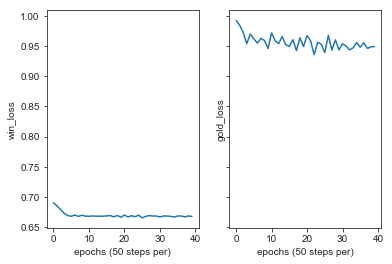

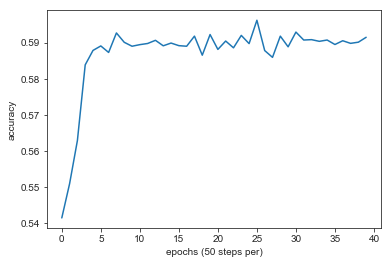

In [91]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_linear_model_dual(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=500,
            epochs=40, 
            aux_weight=0.1,
            training_path=training_file_dual_novocab, 
            validation_path=validation_file_dual_novocab,
            compression_type='GZIP')

### train triple gold_diff, total_gold, radiant_win model

In [15]:
training_file_triple_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'triple_gold_win_novocab_dota2_training_data.tfrecords')
validation_file_triple_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'triple_gold_win_novocab_dota2_validation_data.tfrecords')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191101-195407/saved_model/assets


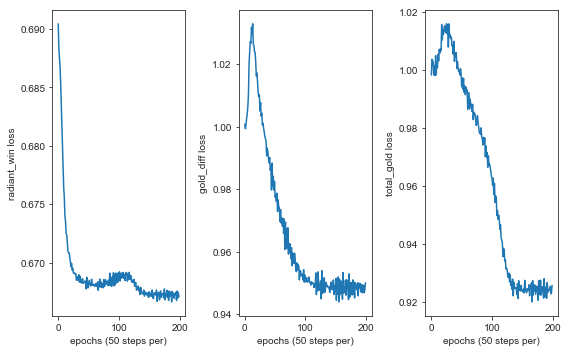

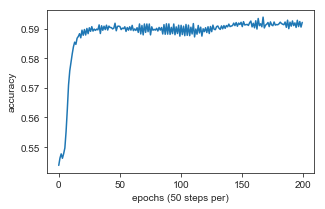

In [190]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_triple(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=2000,
            epochs=200, 
            aux_weight=0.2,
            training_path=training_file_triple_novocab, 
            validation_path=validation_file_triple_novocab,
            compression_type='GZIP')

### train penta linear model (2xgold 2xtower and win)

In [27]:
training_file_penta_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'penta_gold_win_towdam_novocab_dota2_training_data.tfrecords')
validation_file_penta_novocab = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'penta_gold_win_towdam_novocab_dota2_validation_data.tfrecords')

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191106-130632/saved_model/assets


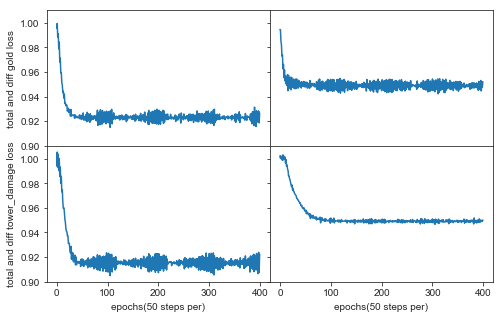

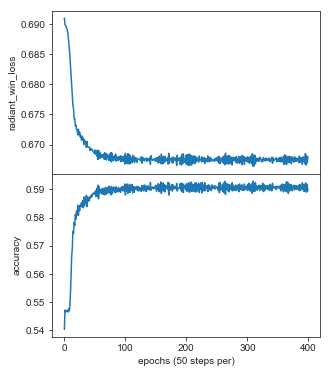

In [45]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191106-145437/saved_model/assets


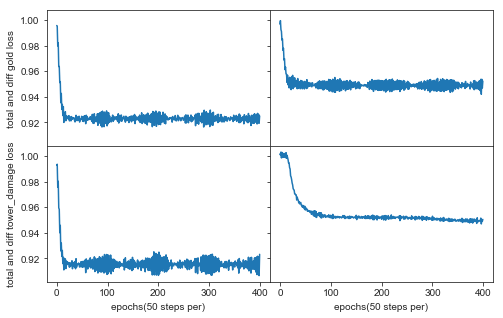

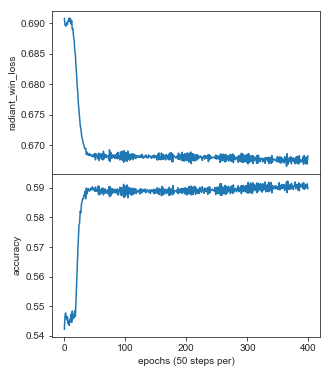

In [46]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191106-191032/saved_model/assets


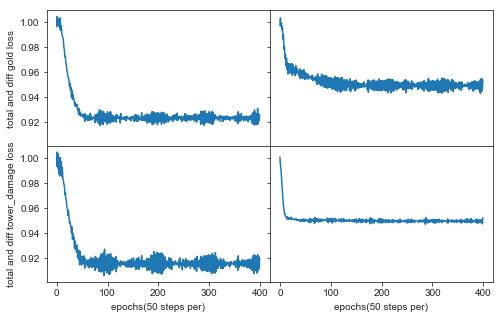

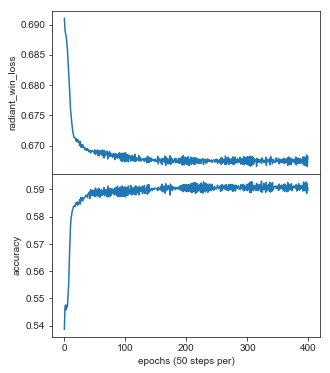

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191106-210855/saved_model/assets


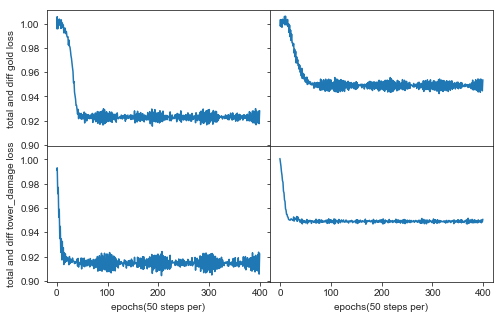

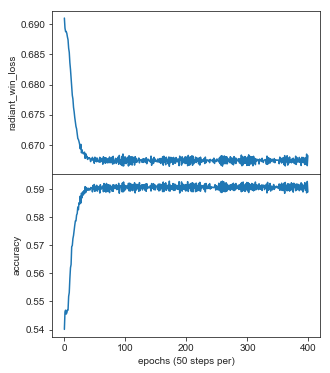

In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=2000,
            epochs=400, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191103-225242/saved_model/assets


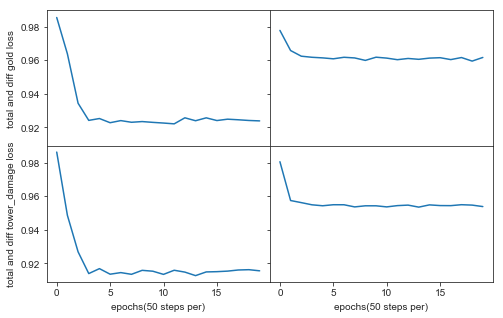

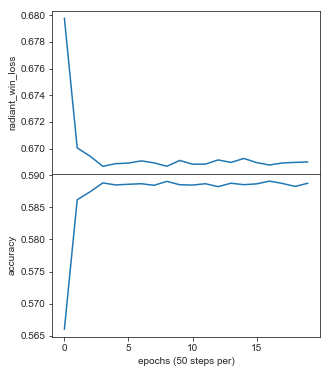

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=3,
            batch_size=10000,
            epochs=20, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191105-013617/saved_model/assets


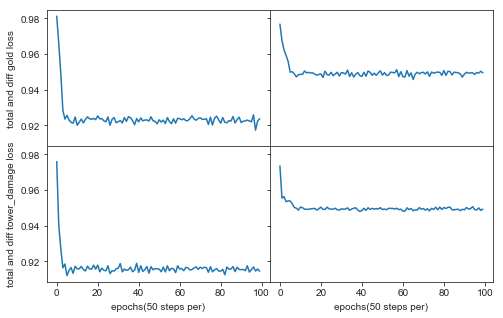

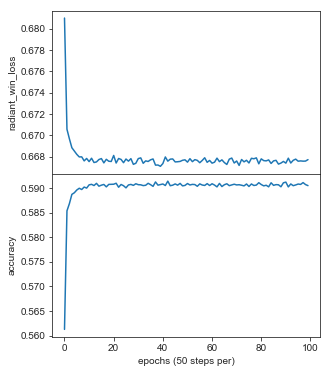

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=10000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/20191105-033542/saved_model/assets


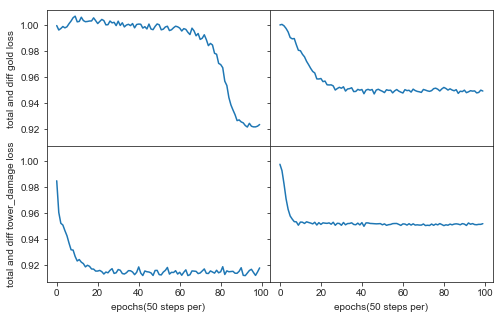

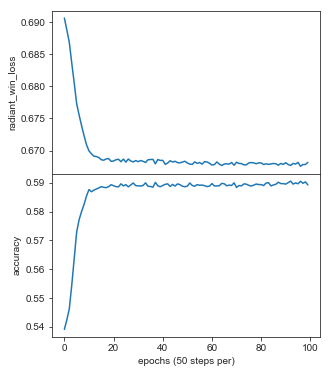

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = train_linear_model_penta_auxconnect(
            optimizer,
            vocab_len=len(hero_vocab),
            embedding_dims=5,
            batch_size=5000,
            epochs=100, 
            aux_weight=0.4,
            training_path=training_file_penta_novocab, 
            validation_path=validation_file_penta_novocab,
            compression_type='GZIP',
            temp_log_flag=True)

### train radiant_win model with feature columns
not needed and possibly a worse architecture (hard to inspect it though)

In [97]:
training_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_training_data',
                             'radiant_windota2_training_data.tfrecords')
validation_file = os.path.join('Dota_data',
                             'mixed_skill',
                             'dota2_validation_data',
                             'radiant_windota2_validation_data.tfrecords')
categorical_columns = [tf.feature_column.categorical_column_with_vocabulary_list(
                                                'radiant_heroes',
                                                hero_vocab),
                               tf.feature_column.categorical_column_with_vocabulary_list(
                                                'dire_heroes',
                                                hero_vocab)]
indicator_columns = [tf.feature_column.indicator_column(
                                        categorical_columns[0]),
                            tf.feature_column.indicator_column(
                                        categorical_columns[1])]
embedding_dim = 3
embedding_columns = [tf.feature_column.embedding_column(
                                categorical_columns[0],
                                embedding_dim),
                    tf.feature_column.embedding_column(
                                categorical_columns[1],
                                embedding_dim)]

In [98]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_model(optimizer,
            indicator_columns,
            batch_size=500, 
            epochs=5, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

NameError: name 'vocab_len' is not defined

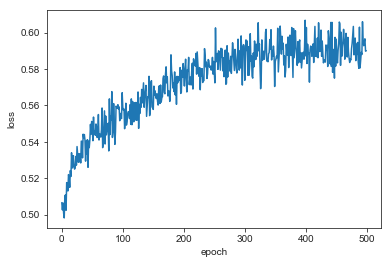

In [82]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=500, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

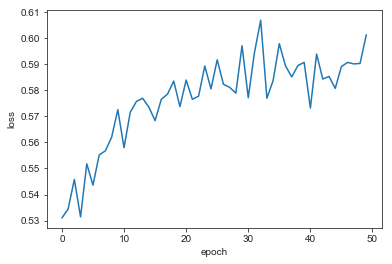

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
history = train_model(optimizer,
            embedding_columns,
            batch_size=500, 
            epochs=50, 
            training_path=training_file, 
            validation_path=validation_file,
            compression_type='GZIP')

In [51]:
%load_ext tensorboard

In [52]:
log = os.path.join('..','..','..','tmp_log_dir')
%tensorboard --logdir '../../../tmp_log_dir' --reload_multifile=true

Reusing TensorBoard on port 6014 (pid 9324), started 21:09:55 ago. (Use '!kill 9324' to kill it.)